In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import transform
import spectral.io.envi as envi

In [2]:
find_index = lambda x, wvls: np.argmin(np.abs(wvls - x), axis = 0)

# 1. LIBS Data Loader

In [3]:
data_folder = r"E:/Data/Data_LIBS/Rock_QLMA/"
hf = h5py.File(data_folder + 'mini_bife_80x80(train).h5', 'r') #'mini_bife_100x110.h5', 'r')
spectrums = np.array(hf.get('intensities'))[1:]
positions = np.array(hf.get('position'))[1:]
wavelengths = np.array(hf.get('wavelengths'))
hf.close()

In [4]:
def make_data_map(spectrums, positions):
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:,0],positions[:,1]))
    spectrums = spectrums[indexes,:]
    spectrums = np.array(spectrums.reshape((ny,nx,-1)))
    print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, positions

In [5]:
libs_maps, libs_positions = make_data_map(spectrums, positions)

(80, 80, 14336)


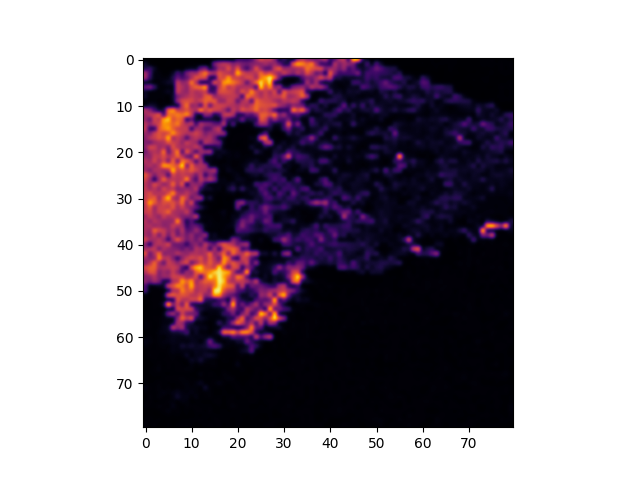

In [21]:
plt.subplots()
plt.imshow(libs_maps[:, :, find_index(610.22, wavelengths)], 
           cmap = 'inferno', interpolation = 'gaussian')

# 2. HSI Data Loader

In [8]:
filen = 'Cavali_amostras_test_A2_2022-05-31_12-38-48'
filen = 'Cavali_amostras_test_A3_2022-05-31_12-40-21'
folder = 'E:/Data/Data_HSI/SWIR_' + filen + '/capture/'


dark_ref = envi.open(folder+'DARKREF_SWIR_' + filen + '.hdr', 
                     folder+'DARKREF_SWIR_' + filen + '.raw')
white_ref = envi.open(folder+'WHITEREF_SWIR_' + filen + '.hdr', 
                      folder+'WHITEREF_SWIR_' + filen + '.raw')
data_ref = envi.open(folder+'SWIR_' + filen + '.hdr', 
                     folder+'SWIR_' + filen + '.raw')

c:\Users\tomas\miniconda3\envs\spectral_env\Lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


# 2.1 HSI pre-processing

The data used for HSI is preprocessed. In other words it is calibrated in accordance to a white and dark reference

In [18]:
white_nparr = np.array(white_ref.load())
dark_nparr = np.array(dark_ref.load())
data_nparr = np.array(data_ref.load())
print(data_nparr.shape)

corrected_nparr = np.divide(data_nparr-dark_nparr.mean(axis = 0),
                            white_nparr.mean(axis = 0)-dark_nparr.mean(axis = 0))[100:250, 100:320]

(354, 384, 284)


C:\Users\tomas\AppData\Local\Temp\ipykernel_16296\424062627.py:6: RuntimeWarning: invalid value encountered in divide
  corrected_nparr = np.divide(data_nparr-dark_nparr.mean(axis = 0),


# 3. Dataset Aligment

In [19]:
im1 = corrected_nparr[:, :, 200]
mmap = libs_maps[:, :, find_index(588.95, wavelengths)]

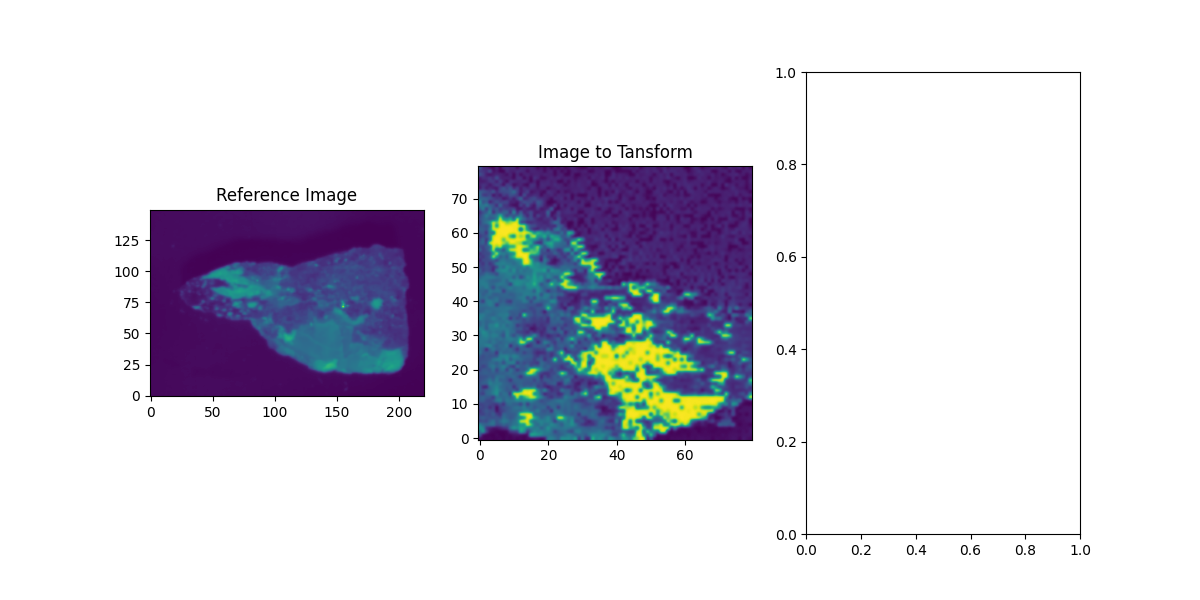

In [30]:
%matplotlib widget
aligner = transform.align(im1, mmap, lognorm = False)

In [31]:
aligner.transform(libs_maps)
new_libs = aligner.new_data

C:\Users\tomas\AppData\Local\Temp\ipykernel_16296\411306385.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2)


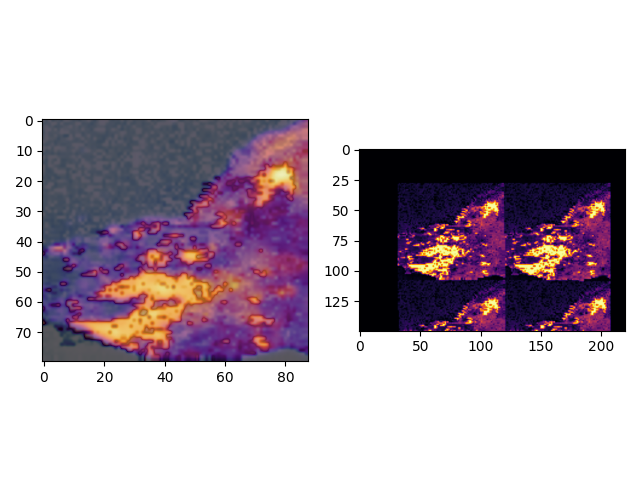

In [37]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
ax.imshow(im1[28:108, 32:120], 
           cmap = 'inferno', interpolation = 'gaussian')
ax.imshow(new_libs[28:108, 32:120, find_index(588.95, wavelengths)], 
           cmap = 'twilight', interpolation = 'gaussian', 
           alpha = 0.4)

ax = axs[1]
ax.imshow(new_libs[:, :, find_index(588.95, wavelengths)], 
           cmap = 'inferno', interpolation = 'gaussian')

fig.tight_layout()

# 4. Save Dataset for training

In [46]:
l_to_save = new_libs[28:108, 32:120]
h_to_save = corrected_nparr[28:108, 32:120]

 = np.array(data_ref.bands.centers)

In [51]:
import h5py

hf = h5py.File("E:/Data/Data_Collab/collab_SLIC.h5", "w")

g_libs = hf.create_group("LIBS")
g_libs.create_dataset("Data", data = l_to_save, dtype = np.float32)
g_libs.create_dataset("Wavelengths", data = wavelengths, dtype = np.float32)

g_hsi = hf.create_group("HSI")
g_hsi.create_dataset("Data", data = h_to_save, dtype = np.float32)
g_hsi.create_dataset("Wavelengths", data = waves_hsi, dtype = np.float32)

hf.close()